In [41]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/session.json"), 'r') as file:
    session_records = json.load(file)
session_records_2 = [s for s in session_records if s.get('bt_sharpe')]
len(session_records)

666

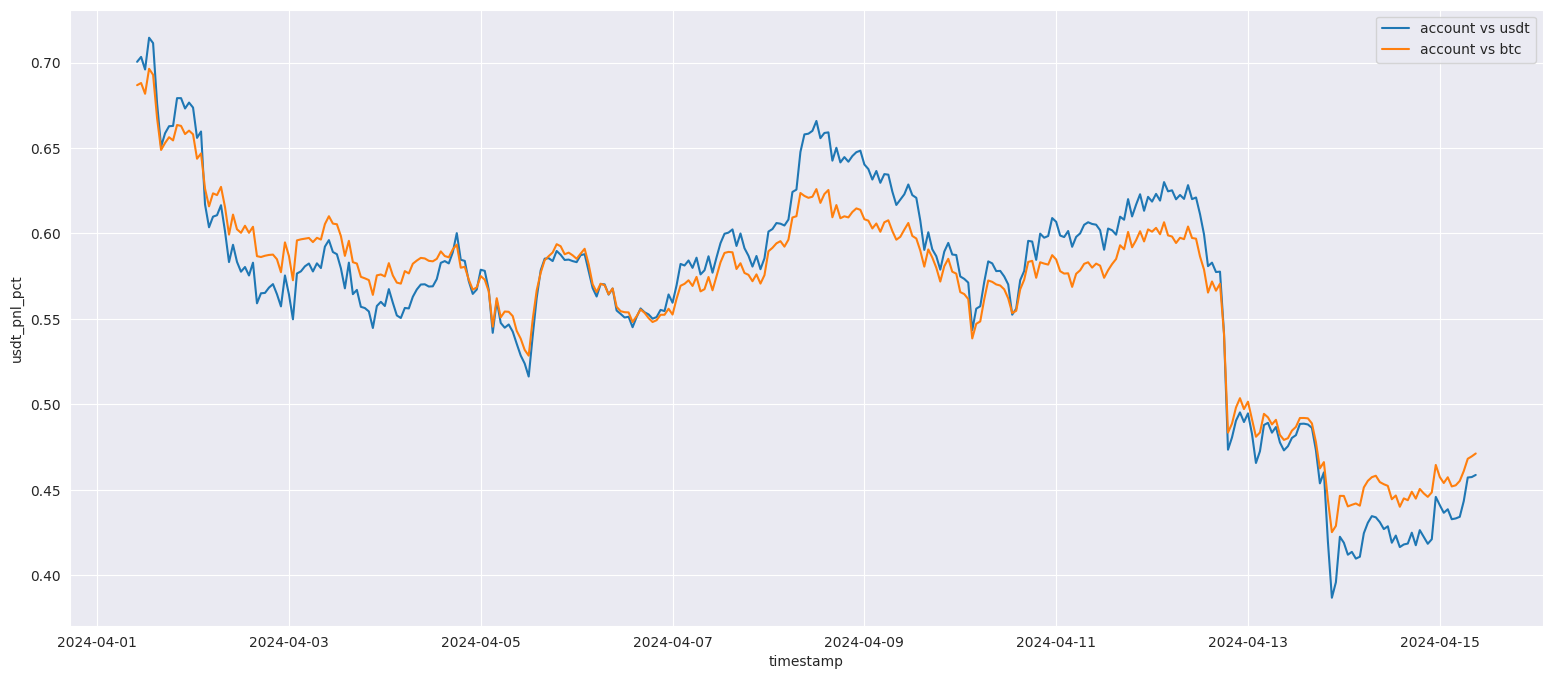

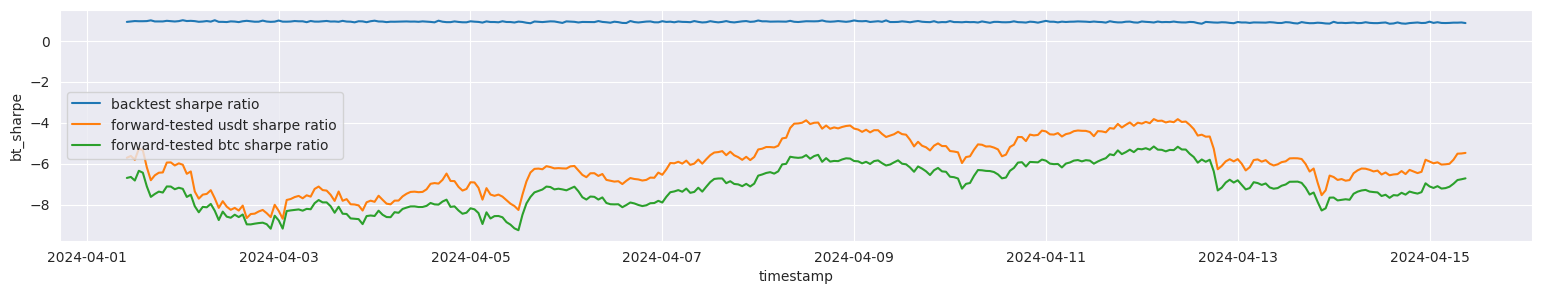

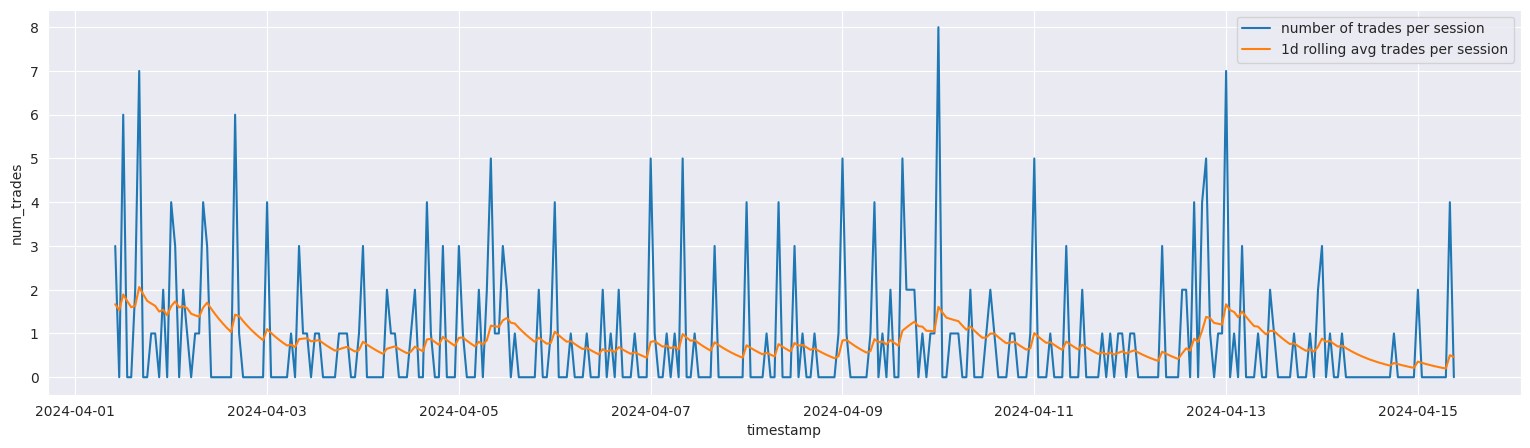

In [43]:
sr = pl.from_dicts(session_records).select(['timestamp', 'usdt_net', 'btc_net', 'trades'])
sr_2 = pl.from_dicts(session_records_2).select(['bt_sharpe'])

sr = sr.with_columns(
    pl.col('timestamp').mul(1000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('usdt_net').truediv(sr.item(0, 'usdt_net')).alias('usdt_pnl_pct'),
    pl.col('usdt_net').pct_change().ewm_mean(span=8760, min_periods=48).mul(8760).truediv(pl.col('usdt_net').pct_change().ewm_std(span=8760, min_periods=48).mul(92)).alias('usdt_sharpe'),
    pl.col('btc_net').truediv(sr.item(0, 'btc_net')).alias('btc_pnl_pct'),
    pl.col('btc_net').pct_change().ewm_mean(span=8760, min_periods=48).mul(8760).truediv(pl.col('btc_net').pct_change().ewm_std(span=8760, min_periods=48).mul(92)).alias('btc_sharpe'),
    pl.col('trades').alias('num_trades'),
    pl.col('trades').ewm_mean(span=24).alias('avg_trades'),
)
sr = sr.tail(len(sr_2)).with_columns(sr_2['bt_sharpe'].alias('bt_sharpe')).tail(336)

plt.figure(figsize=(19, 8))
sns.lineplot(data=sr, x='timestamp', y='usdt_pnl_pct', label='account vs usdt')
sns.lineplot(data=sr, x='timestamp', y='btc_pnl_pct', label='account vs btc')
plt.show()
plt.figure(figsize=(19, 3))
sns.lineplot(data=sr, x='timestamp', y='bt_sharpe', label='backtest sharpe ratio')
sns.lineplot(data=sr, x='timestamp', y='usdt_sharpe', label='forward-tested usdt sharpe ratio')
sns.lineplot(data=sr, x='timestamp', y='btc_sharpe', label='forward-tested btc sharpe ratio')
plt.show()
plt.figure(figsize=(19, 5))
sns.lineplot(data=sr, x='timestamp', y='num_trades', label='number of trades per session')
sns.lineplot(data=sr, x='timestamp', y='avg_trades', label='1d rolling avg trades per session')
plt.show()

In [24]:
session_records

[{'timestamp': 1710759988.565381,
  'port_weights': 'perf',
  'usdt_net': 6859.096245400716,
  'btc_net': 0.10080339,
  'max_leverage': 3,
  'buffer': 0.2,
  'flat_allocations': {'BTCUSDT': 0.053717894110824005,
   'SOLUSDT': 0.10486330219532364,
   'NEARUSDT': 0.05998044039681414,
   'ROSEUSDT': -0.00016189718779954296,
   'OCEANUSDT': 0.024689402997236737,
   'ETHUSDT': -0.004010520065064676,
   'MATICUSDT': -0.04176164327650449,
   'AVAXUSDT': 0.075835960999921},
  'lin_allocations': {'BTCUSDT': 0.09549847841924267,
   'SOLUSDT': 0.16312069230383677,
   'NEARUSDT': 0.07997392052908552,
   'ROSEUSDT': -0.0001798857642217144,
   'OCEANUSDT': 0.021946135997543765,
   'ETHUSDT': -0.0026736800433764503,
   'MATICUSDT': -0.018560730345113106,
   'AVAXUSDT': 0.016852435777760223},
  'perf_allocations': {'BTCUSDT': 0.01766164618594348,
   'SOLUSDT': 0.1771286172572418,
   'NEARUSDT': 0.05980203270580747,
   'ROSEUSDT': -0.00012278009295297812,
   'OCEANUSDT': 0.0,
   'ETHUSDT': -0.003306859